<a href="https://www.kaggle.com/code/abhigyan2004/sentiment-analysis-python?scriptVersionId=247270354" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)
df = df.head(10000)
print(df.shape)

(568454, 10)
(10000, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

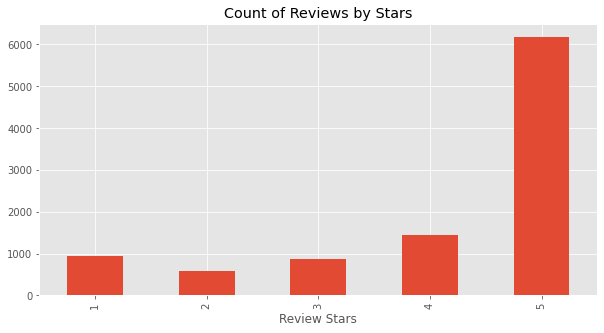

In [4]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [5]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [7]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [8]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [10]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [12]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

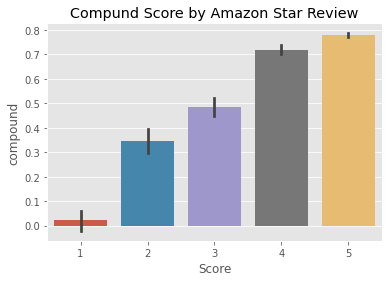

In [16]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

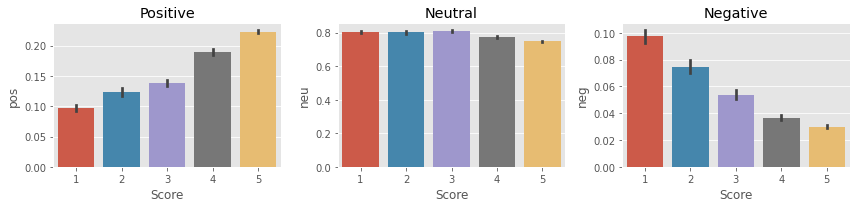

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [18]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [20]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [21]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9763551, 'roberta_neu': 0.020687468, 'roberta_pos': 0.0029573687}


In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [23]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4110
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 4583
Broke for id 5040
Broke for id 5182
Broke for id 5192
Broke for id 5365
Broke for id 5442
Broke for id 5709
Broke for id 5998
Broke for id 6003
Broke for id 6007
Broke for id 6106
Broke for id 6234
Broke for id 6558

In [24]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [25]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 3. Combine and compare

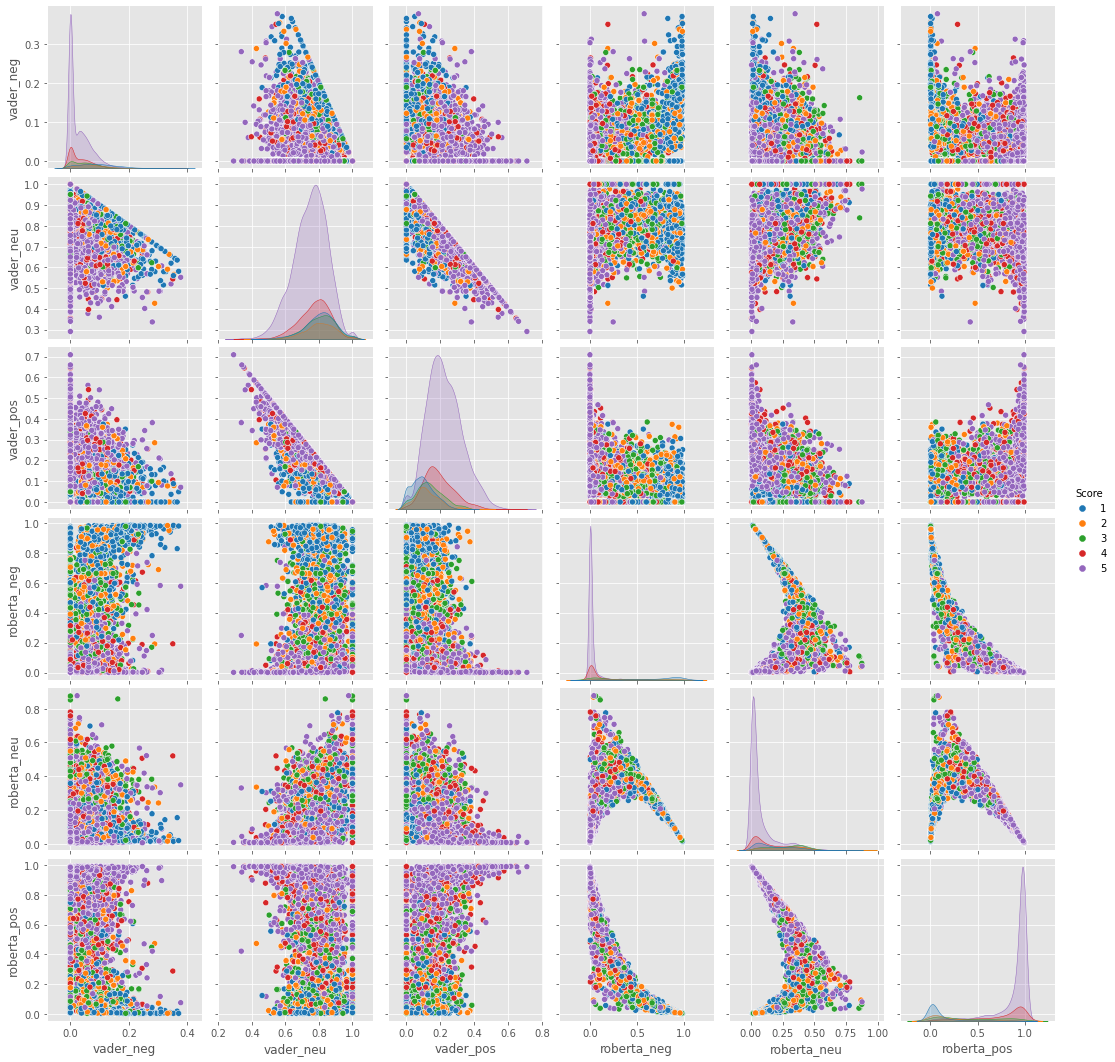

In [26]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [27]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [28]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!'

In [29]:
# nevative sentiment 5-Star view

In [30]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'They have a bad taste,i finish giving them away because my son started to cry everytime i tried to give these.I prefer Beech nut or Gerber.Yuck!'

In [31]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'My two cats must not be interested in grass, because it grew but they ignored it. Had no problems growing it.'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [32]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [33]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [34]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [35]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The End

In [36]:
# 🧠 Required Libraries
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax
import torch
from tqdm import tqdm
import nltk

# 🔧 NLTK Setup (only once)
nltk.download('vader_lexicon')

# 🔧 Load Sample Dataset (or use your own)
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
df = df[['Id', 'Text', 'Score']].dropna().head(100)  # subset for speed

# ✅ Initialize Models
# VADER
sia = SentimentIntensityAnalyzer()

# RoBERTa
roberta_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer_roberta = AutoTokenizer.from_pretrained(roberta_model_name)
model_roberta = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

# Hugging Face Pipeline
hf_pipeline = pipeline("sentiment-analysis")

# ✅ Function: Get All Sentiment Scores
def get_all_sentiment_scores(text):
    # --- VADER ---
    vader_scores = sia.polarity_scores(text)
    
    # --- RoBERTa ---
    encoded = tokenizer_roberta(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model_roberta(**encoded)
    scores = softmax(output.logits.numpy()[0])
    roberta_scores = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

    # --- Hugging Face Pipeline ---
    try:
        result = hf_pipeline(text[:512])[0]  # Truncate if too long
        label = result['label']
        score = result['score']
        hf_label = {'LABEL_0': 'NEGATIVE', 'LABEL_1': 'NEUTRAL', 'LABEL_2': 'POSITIVE'}
        hf_sentiment = {
            'hf_label': label,
            'hf_score': score
        }
    except:
        hf_sentiment = {
            'hf_label': 'ERROR',
            'hf_score': 0.0
        }

    # Combine all
    return {
        'vader_neg': vader_scores['neg'],
        'vader_neu': vader_scores['neu'],
        'vader_pos': vader_scores['pos'],
        'vader_compound': vader_scores['compound'],
        **roberta_scores,
        **hf_sentiment
    }

# ✅ Apply to DataFrame
all_results = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    row_result = get_all_sentiment_scores(row['Text'])
    row_result['Id'] = row['Id']
    row_result['Score'] = row['Score']
    row_result['Text'] = row['Text']
    all_results.append(row_result)

results_df = pd.DataFrame(all_results)

# ✅ Show Comparison
results_df[['Id', 'Score', 'vader_pos', 'roberta_pos', 'hf_label', 'hf_score']].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


,Id,Score,vader_pos,roberta_pos,hf_label,hf_score
0,1,5,0.305,0.940395,POSITIVE,0.998385
1,2,1,0.068,0.038600,NEGATIVE,0.999525
2,3,4,0.155,0.898704,POSITIVE,0.999765
3,4,2,0.000,0.907486,POSITIVE,0.999153
4,5,5,0.448,0.988063,POSITIVE,0.998708
5,6,4,0.163,0.972075,POSITIVE,0.999255
6,7,5,0.273,0.990921,POSITIVE,0.999364
7,8,5,0.480,0.992286,POSITIVE,0.999883
8,9,5,0.149,0.901970,POSITIVE,0.998517
9,10,5,0.295,0.940984,POSITIVE,0.999456


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


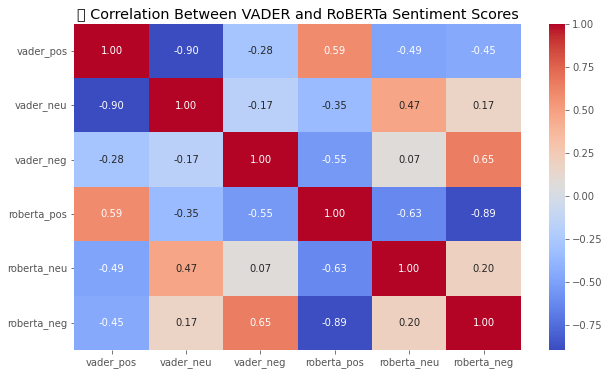

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 📊 Heatmap of Correlation between Models
plt.figure(figsize=(10, 6))
sns.heatmap(
    results_df[['vader_pos', 'vader_neu', 'vader_neg', 
                'roberta_pos', 'roberta_neu', 'roberta_neg']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("🔁 Correlation Between VADER and RoBERTa Sentiment Scores")
plt.show()


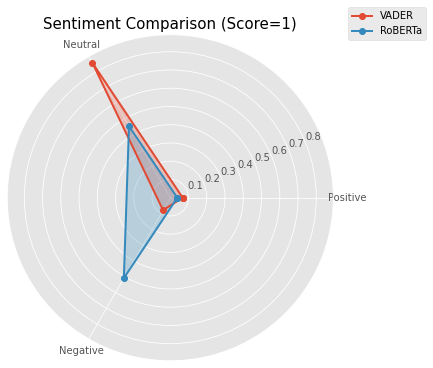

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_comparison(row):
    # Extract data for one row
    categories = ['Positive', 'Neutral', 'Negative']
    vader_values = [row['vader_pos'], row['vader_neu'], row['vader_neg']]
    roberta_values = [row['roberta_pos'], row['roberta_neu'], row['roberta_neg']]

    # Radar setup
    values = np.array([vader_values, roberta_values])
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values = np.concatenate((values, values[:,[0]]), axis=1)
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    ax.plot(angles, values[0], 'o-', linewidth=2, label='VADER')
    ax.fill(angles, values[0], alpha=0.25)
    
    ax.plot(angles, values[1], 'o-', linewidth=2, label='RoBERTa')
    ax.fill(angles, values[1], alpha=0.25)

    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_title(f"Sentiment Comparison (Score={row['Score']})", size=15)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# 🔍 Example: Visualize first 1-star review
one_star = results_df.query("Score == 1").iloc[0]
plot_radar_comparison(one_star)
